In [7]:
import time
import numpy as np
import h5py
import hdf5plugin
import pandas as pd
import matplotlib as mpl
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz, kelvin
from astropy.cosmology import Planck18 as cosmo
from scipy import signal
import os 
import csv
import resource
import pickle
import shutil
import json

from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.filters import UVJ
from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.sed import Sed
from synthesizer.parametric import SFH, ZDist
from synthesizer.particle.stars import sample_sfhz
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle.particles import CoordinateGenerator
from synthesizer.filters import Filter, FilterCollection
from synthesizer.sed import combine_list_of_seds
from synthesizer.kernel_functions import Kernel
from synthesizer.conversions import lnu_to_absolute_mag
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody, Greybody
from synthesizer.emission_models import (
    EmissionModel,
    AttenuatedEmission,
    BimodalPacmanEmission,
    DustEmission,
    EmissionModel,
    UnifiedAGN,
    CharlotFall2000,
    IncidentEmission,
    NebularEmission,
    ReprocessedEmission,
    StellarEmissionModel,
)

In [8]:

    
# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_lf(ab_mag, volume, massBinLimits):
    try:
        # OG: hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])
        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors
        return phi, phi_sigma, hist
    except Exception as e:
        print(f"Error in calc_lf: {e}")
        return None, None, None


In [15]:
# Define directories to process
LH_X ='LH_9'

# Initialize grid
grid_name = "bc03_chabrier03-0.1,100.hdf5"
grid_dir = "/home/jovyan/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

# Define the directory where the text files will be saved
output_dir = "/home/jovyan/camels/LH_set/get_LF/LF_outputs/"


In [16]:
LH_X

'LH_9'

# set up intrinsic emissions model
# NOT USING CURRENTLY, START WITH BASIC INTRINSIC EMISSION:

# Get the stellar pacman model
pc_model = BimodalPacmanEmission(
    grid=grid,
    tau_v_ism=1.0,
    tau_v_birth=0.7,
    dust_curve_ism=PowerLaw(slope=-1.3),
    dust_curve_birth=PowerLaw(slope=-0.7),
    dust_emission_ism=Blackbody(temperature=100 * kelvin),
    dust_emission_birth=Blackbody(temperature=30 * kelvin),
    fesc=0.2,
    fesc_ly_alpha=0.9,
    label="stellar_total",
)

# Get the UnifiedAGN model
uni_model = UnifiedAGN(
    nlr_grid,
    blr_grid,
    covering_fraction_nlr=0.1,
    covering_fraction_blr=0.1,
    torus_emission_model=Blackbody(1000 * kelvin),
    label="agn_intrinsic",
)

gal_intrinsic = EmissionModel(
    label="total_intrinsic",
    combine=(uni_model, pc_model["intrinsic"]),
    emitter="galaxy",
)

gal_total = EmissionModel(
    label="total",
    combine=(gal_attenuated, gal_dust),
    related_models=(gal_intrinsic,),
    emitter="galaxy",
)


In [17]:
incident = IncidentEmission(grid)
little_h =  0.6711


In [18]:

# Create an empty dictionary to store your data - reset in loop
data_dict = {}

# Get grid for all galaxies
dir_ = '/home/jovyan/Data/Sims/IllustrisTNG/LH/' + LH_X
gals_074 = load_CAMELS_IllustrisTNG(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
)

cat_074 = dir_+'/groups_074.hdf5'
# Open file
f_h5py = h5py.File(cat_074, 'r')

# Read different attributes of the header
boxSize_074 = f_h5py['Header'].attrs[u'BoxSize']/1e3 # Mpc/h
redshift_074 = f_h5py['Header'].attrs[u'Redshift']

# Filter galaxies to only include those with 100 or more star particles
gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]



spec_list = []
# Lets work with z=0.475 so gals_p10
for i in gals_074:
    gal = i
    # To get a spectra we just call the `get_spectra` method on the stars with
    # whatever emission model we want to use, here the incident model.
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)

# Combine spectra
seds = combine_list_of_seds(spec_list)



# flters:
# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
#fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
#fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# tophat filter
filt1 = Filter("top_hat/filter.1", lam_min=1400, lam_max=1600, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1]#, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)

seds.lnu  # rest frame lumd
seds.get_photo_lnu(combined_filters, verbose=True) 
#Calculate broadband luminosities using a FilterCollection object   
# conversion is done using:

#    M = -2.5 * log10(L_nu / dist_mod / (erg / s / Hz)) - 48.6

abs_mag = lnu_to_absolute_mag(seds.lnu)
abs_mag_th = abs_mag[0]

# Calculate luminosity function
Vphys = (boxSize_074 / little_h) ** 3
Vcom = Vphys * ((1 + redshift_074) ** 3)

massBinLimits = np.arange(-22, -16, 0.5)
phi, phi_sigma, hist = calc_lf(abs_mag_th, Vcom, massBinLimits)

if phi is None or phi_sigma is None or hist is None:
    raise ValueError("Error in luminosity function calculation")

massBinLimits = massBinLimits[:-1]

# Define output file path
output_file = f"{output_dir}{LH_X}.txt"

# Write the data to the text file
with open(output_file, 'w') as txtfile:
    # Write phi values
    txtfile.write("phi\n")
    for value in phi:
        txtfile.write(f"{value}\n")

    # Write phi_sigma values
    txtfile.write("phi_sigma\n")
    for value in phi_sigma:
        txtfile.write(f"{value}\n")

    # Write hist values
    txtfile.write("hist\n")
    for value in hist:
        txtfile.write(f"{value}\n")

    # Write massBinLimits values
    txtfile.write("massBinLimits\n")
    for value in massBinLimits:
        txtfile.write(f"{value}\n")

print(f'Written out: {output_file}')


Written out: /home/jovyan/camels/LH_set/get_LF/LF_outputs/LH_9.txt


In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicities` is not provided, setting `stars` object to `None`
In `load_stars`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
In `load_stars`: one of either `initial_masses`, `ages` or `metallicitie

KeyboardInterrupt: 

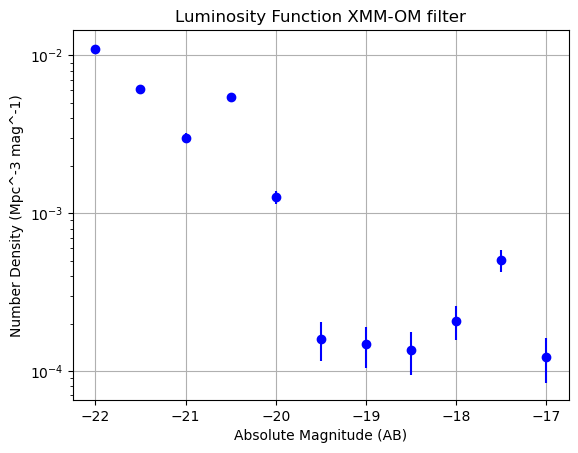

In [19]:
# will do latest LH_ set in loop as a test
label_z = 'z = 0.46'


# Plot the luminosity function
plt.errorbar(massBinLimits, phi, yerr=phi_sigma, fmt='o', color='blue',label=label_z)
plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')

plt.title('Luminosity Function XMM-OM filter')
plt.grid(True)
plt.show()

In [20]:
LH_X

'LH_9'